In [1]:
import pickle
import pandas as pd
import seaborn as sns

In [2]:
air_df = pickle.load(open("air_df_1.p",'rb'))
open('air_df_1.p','rb').close

<function BufferedReader.close>

In [3]:
air_df.sort_values(by='Date',inplace=True)
df =air_df[['Date','Daily Max 8-hour Ozone Concentration']]
df.set_index('Date',inplace=True)

In [4]:
import plaidml.keras
plaidml.keras.install_backend()

from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [5]:
pred_scaler = MinMaxScaler(feature_range = (0, 1))
pred_scaler = pred_scaler.fit(np.array(df['Daily Max 8-hour Ozone Concentration']).reshape(-1, 1))

In [6]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# load dataset
values = df.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
# drop columns we don't want to predict
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.246377,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870
8,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478
9,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493
10,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942
11,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899


In [9]:
y = reframed.iloc[:,-1].values
X = reframed.drop(['var1(t)'], axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 7) (3100,) (505, 1, 7) (505,) (360, 1, 7) (360,)


INFO:plaidml:Opening device "opencl_amd_radeon_pro_560x_compute_engine.0"


Train on 3100 samples, validate on 505 samples
Epoch 1/200
 - 2s - loss: 0.2210 - val_loss: 0.0850
Epoch 2/200
 - 2s - loss: 0.0847 - val_loss: 0.0782
Epoch 3/200
 - 1s - loss: 0.0794 - val_loss: 0.0749
Epoch 4/200
 - 2s - loss: 0.0764 - val_loss: 0.0714
Epoch 5/200
 - 1s - loss: 0.0740 - val_loss: 0.0688
Epoch 6/200
 - 1s - loss: 0.0724 - val_loss: 0.0674
Epoch 7/200
 - 1s - loss: 0.0707 - val_loss: 0.0685
Epoch 8/200
 - 1s - loss: 0.0697 - val_loss: 0.0659
Epoch 9/200
 - 1s - loss: 0.0688 - val_loss: 0.0650
Epoch 10/200
 - 1s - loss: 0.0685 - val_loss: 0.0658
Epoch 11/200
 - 2s - loss: 0.0685 - val_loss: 0.0643
Epoch 12/200
 - 1s - loss: 0.0681 - val_loss: 0.0642
Epoch 13/200
 - 1s - loss: 0.0679 - val_loss: 0.0638
Epoch 14/200
 - 1s - loss: 0.0675 - val_loss: 0.0672
Epoch 15/200
 - 1s - loss: 0.0677 - val_loss: 0.0637
Epoch 16/200
 - 1s - loss: 0.0676 - val_loss: 0.0669
Epoch 17/200
 - 1s - loss: 0.0676 - val_loss: 0.0636
Epoch 18/200
 - 2s - loss: 0.0675 - val_loss: 0.0643
Epoch 19

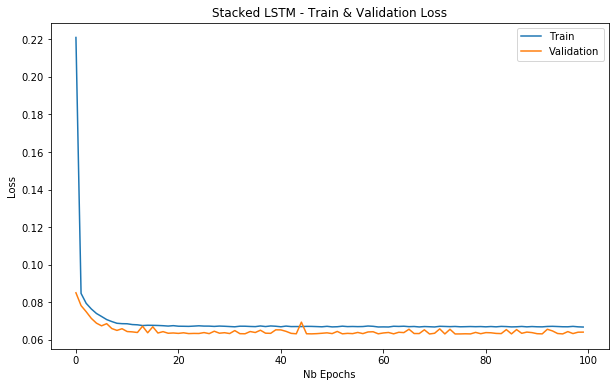

Minimum validation loss of 0.0630521495596017 reached at epoch 69


In [10]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

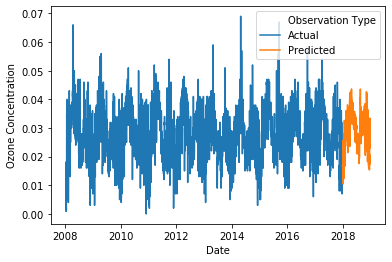

In [11]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':df.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':df.index[3107:-360]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':df.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me = pd.concat([train_data,val_data,test_data])
plot_me['Ozone Concentration'] = pred_scaler.inverse_transform(np.array(plot_me['Ozone Concentration']).reshape(-1, 1))
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])

In [12]:
plot_me_single=plot_me

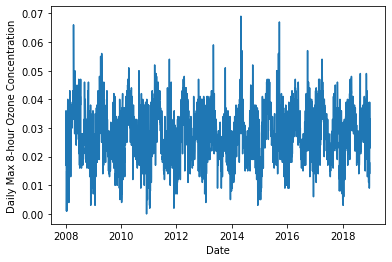

In [13]:
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])

In [14]:
dataset= pickle.load(open('ts_with_weather_sf.p', 'rb'))

In [15]:
values = dataset.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
# drop columns we don't want to predict

reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
7,0.246377,0.010613,0.189808,0.258421,0.443965,0.594937,0.784750,0.240483,0.183844,0.26,...,0.028973,0.139877,0.319737,0.574451,0.835443,0.702442,0.357474,0.456825,0.83,0.0
8,0.347826,0.012735,0.220417,0.403684,0.495102,0.658228,0.683680,0.046425,0.320334,0.44,...,0.032263,0.113201,0.373947,0.622845,0.924051,0.802299,0.050139,0.961003,0.90,0.0
9,0.434783,0.015017,0.231874,0.498947,0.633817,0.772152,0.585436,0.503250,0.434540,0.93,...,0.035765,0.128078,0.422105,0.658503,0.949367,0.789186,0.044568,0.144847,1.00,0.0
10,0.521739,0.017458,0.236491,0.375526,0.699256,0.873418,0.359291,0.675952,0.518106,0.87,...,0.039374,0.167066,0.363947,0.663597,0.911393,0.790600,0.155989,0.061281,0.90,0.0
11,0.478261,0.020058,0.135773,0.248947,0.582093,0.810127,0.471455,0.390901,0.537604,0.69,...,0.043141,0.227599,0.331842,0.621473,0.822785,0.815615,0.122563,0.061281,0.49,0.0


In [16]:
y = reframed.iloc[:,-11].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 87) (3100,) (505, 1, 87) (505,) (360, 1, 87) (360,)


In [17]:
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)

Train on 3100 samples, validate on 505 samples
Epoch 1/150
 - 3s - loss: 0.1883 - val_loss: 0.0978
Epoch 2/150
 - 3s - loss: 0.1005 - val_loss: 0.0961
Epoch 3/150
 - 3s - loss: 0.0972 - val_loss: 0.0940
Epoch 4/150
 - 3s - loss: 0.0944 - val_loss: 0.0903
Epoch 5/150
 - 3s - loss: 0.0909 - val_loss: 0.0856
Epoch 6/150
 - 3s - loss: 0.0870 - val_loss: 0.0793
Epoch 7/150
 - 3s - loss: 0.0821 - val_loss: 0.0710
Epoch 8/150
 - 3s - loss: 0.0770 - val_loss: 0.0692
Epoch 9/150
 - 3s - loss: 0.0762 - val_loss: 0.0671
Epoch 10/150
 - 3s - loss: 0.0736 - val_loss: 0.0664
Epoch 11/150
 - 3s - loss: 0.0716 - val_loss: 0.0657
Epoch 12/150
 - 3s - loss: 0.0700 - val_loss: 0.0640
Epoch 13/150
 - 3s - loss: 0.0702 - val_loss: 0.0646
Epoch 14/150
 - 3s - loss: 0.0714 - val_loss: 0.0638
Epoch 15/150
 - 3s - loss: 0.0707 - val_loss: 0.0640
Epoch 16/150
 - 3s - loss: 0.0700 - val_loss: 0.0637
Epoch 17/150
 - 3s - loss: 0.0701 - val_loss: 0.0640
Epoch 18/150
 - 3s - loss: 0.0688 - val_loss: 0.0647
Epoch 19

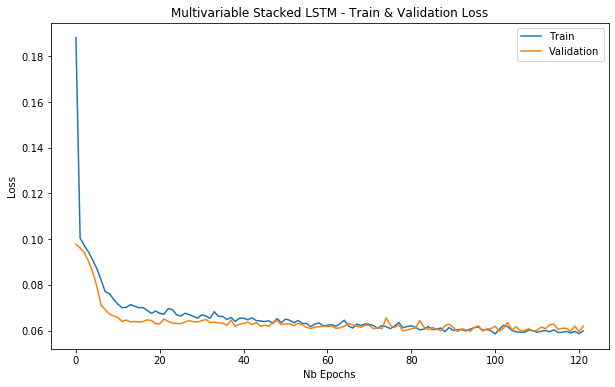

Minimum validation loss of 0.05951210546611559 reached at epoch 91


In [18]:
stacked_lstm = Sequential()
# stacked_lstm.add(LSTM(600, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3, 
#                        return_sequences=True))
# stacked_lstm.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3 ,
#                  return_sequences = True))
# stacked_lstm.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.3, recurrent_dropout=0.3 ))
# stacked_lstm.add(Dense(200))
# stacked_lstm.add(Dropout(.3))
# stacked_lstm.add(Dense(1))



stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]),dropout=0.05, recurrent_dropout=0.05, return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))

stacked_lstm.compile(loss='mae', optimizer='adam')
# fit network
history = stacked_lstm.fit(train_X, train_y, epochs=150, 
                            batch_size=20, 
                            validation_data=(val_X, val_y),
                            callbacks=[earlystopper],
                            verbose=2, shuffle=False)
# plot history
plot_loss(history, 'Multivariable Stacked LSTM - Train & Validation Loss')

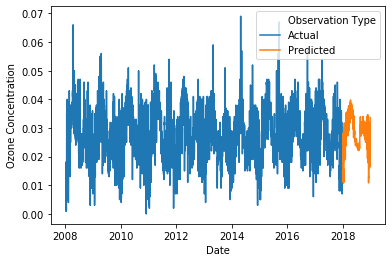

In [19]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':dataset.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':dataset.index[3107:-360]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':dataset.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me_multi = pd.concat([train_data,val_data,test_data])

plot_me_multi['Ozone Concentration'] = pred_scaler.inverse_transform(np.array(plot_me_multi['Ozone Concentration']).reshape(-1, 1))

sns.lineplot(x=plot_me_multi.Date,y=plot_me_multi['Ozone Concentration'],hue=plot_me_multi['Observation Type'])

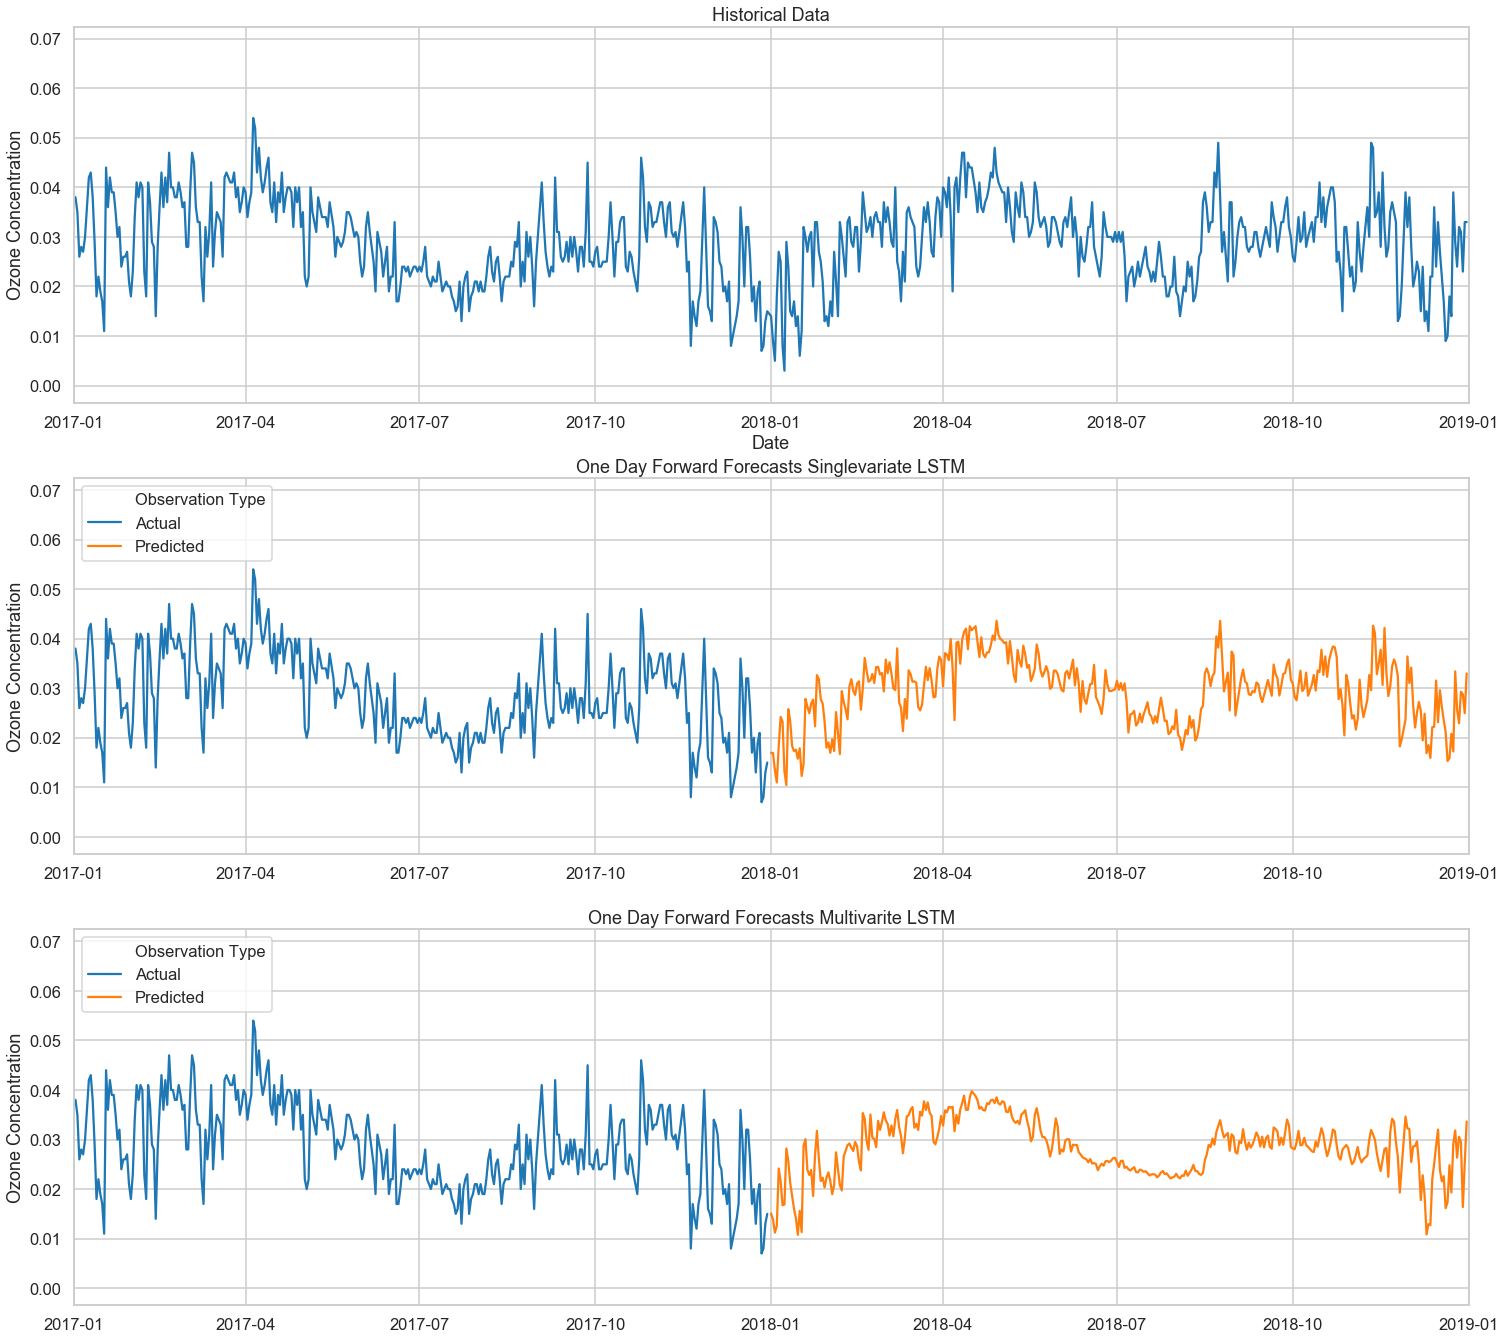

In [23]:
sns.set_style('whitegrid')
sns.set_context('talk')


plt.figure(figsize=(25,2))


plt.subplot(3,1,1)
plt.title('Historical Data')
sns.lineplot(x=dataset.index,y=dataset['Daily Max 8-hour Ozone Concentration'])
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))   
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -8, right=None, top=None, wspace=None, hspace=None)

plt.subplot(3,1,2)
plt.title('One Day Forward Forecasts Singlevariate LSTM')
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])
plt.legend(loc='upper left')
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))  
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -8, right=None, top=None, wspace=None, hspace=None)

plt.xlabel('')

plt.subplot(3,1,3)
plt.title('One Day Forward Forecasts Multivarite LSTM')
sns.lineplot(x=plot_me_multi.Date,y=plot_me_multi['Ozone Concentration'],hue=plot_me_multi['Observation Type'])
plt.legend(loc='upper left')
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))  
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -8, right=None, top=None, wspace=None, hspace=None)
plt.xlabel('')

plt.savefig('oneMultiSingleHistorical.png',dpi =250, bbox_inches='tight')